# Extra Optional Exercise: GeoViz

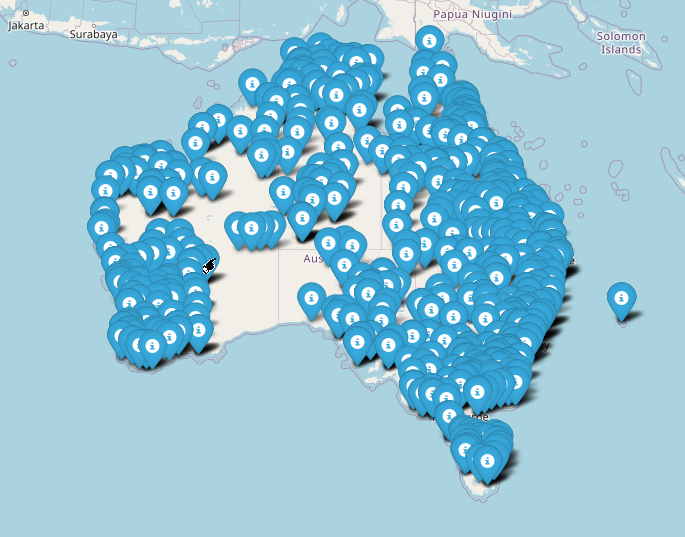

- Spin up your [GitHub Codespace](https://github.com/codespaces)
- Upload the database `abcTransmissions.json`, which contains information about 1'054 radio stations in Australia
- Load the JSON into a MongoDB database using `pymongo` 
- Show all stations on a map using a library like `folium` (see example below)
- *Bonus 1*: make a histogram of how many stations there are per radio frequency
- *Bonus 2*: find the most isolated station (i.e. the one that is furthest away from any other station) and show it on the map

**I hope to see your results next time!**

**You are allowed to use chatGPT if you want** -- just make it work!

This is how the dataset looks like:

```
{"_id":1,"name":"Adelaide","state":"SA","network":"Radio National","frequency":{"$numberDecimal":"729"},"band":"AM","location":{"type":"Point","coordinates":[138.5999594,-34.9286212]},"stateName":"South Australia"}
{"_id":2,"name":"Adelaide","state":"SA","network":"ABC Local","frequency":{"$numberDecimal":"891"},"band":"AM","location":{"type":"Point","coordinates":[138.5999594,-34.9286212]},"stateName":"South Australia"}
{"_id":3,"name":"Adelaide","state":"SA","network":"Classic FM","frequency":{"$numberDecimal":"103.9"},"band":"FM","location":{"type":"Point","coordinates":[138.5999594,-34.9286212]},"stateName":"South Australia"}
...
```

In [3]:
"""
Folium Example

Note that you will need to install:
    - folium
    - rasterio
    - earthpy
"""

import os 
import folium
from folium import plugins
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import earthpy as et

# Create a map using Stamen Terrain, centered on Boulder, CO
m = folium.Map(location=[40.0150, -105.2705])

# Add marker for Boulder, CO
folium.Marker(
    location=[40.009515, -105.242714], # coordinates for the marker (Earth Lab at CU Boulder)
    popup='Earth Lab at CU Boulder', # pop-up label for the marker
    icon=folium.Icon()
).add_to(m)

# Display m
m


In [8]:
pip install earthpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 38.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 47.3 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 8.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 54.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 5.6 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
import os 
import folium
from folium import plugins
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import earthpy as et


In [10]:
import json
from pymongo import MongoClient

In [25]:
# Establish connection to MongoDB
client = MongoClient('localhost', 27017)
db = client.test_database
collection = db.collection

# Clear the collection
collection.drop()


In [26]:
with open('abcTransmissions.json', 'r') as data_file:  # Remember to change the file path as needed
    data_json = json.load(data_file)
    db.collection.insert_many(data_json)

In [37]:
import os 
import folium
from folium import plugins
import json
from pymongo import MongoClient

# Establish connection to MongoDB
client = MongoClient('localhost', 27017)
db = client.test_database
collection = db.collection

# Clear the collection
collection.drop()

# Load data from JSON file and insert into MongoDB collection, handling duplicates
with open('abcTransmissions.json', 'r') as data_file:
    data_json = json.load(data_file)
    for doc in data_json:
        try:
            collection.insert_one(doc)
        except Exception as e:
            print(f"Skipping document with duplicate _id: {doc['_id']}")
            continue

# Create a map centered around Australia
m = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)

# Add markers for each station
for station in collection.find():
    location = station['location']['coordinates'][::-1]  # Reversed coordinates for Folium
    folium.Marker(location=location, popup=station['name']).add_to(m)

# Create a heatmap layer using station locations
station_heatmap_data = [[station['location']['coordinates'][1], station['location']['coordinates'][0]] 
                        for station in collection.find()]
heatmap = plugins.HeatMap(station_heatmap_data)
m.add_child(heatmap)

# Save the map to an HTML file
m.save('radio_stations_map_with_heatmap.html')

print("Map with heatmap saved successfully!")
m

Map with heatmap saved successfully!


*Bonus 1*: make a histogram of how many stations there are per radio frequency



*Bonus 2*: find the most isolated station (i.e. the one that is furthest away from any other station) and show it on the map


In [39]:
import numpy as np
from geopy.distance import geodesic

# Initialize variables to store the most isolated station and its distance
most_isolated_station = None
max_distance = 0

# Iterate through each station
for station in collection.find():
    location = station['location']['coordinates'][::-1]  # Reversed coordinates for Folium
    station_coord = tuple(location)
    station_name = station['name']
    
    # Initialize variables to store the minimum distance between this station and others
    min_distance = np.inf
    
    # Iterate through each other station
    for other_station in collection.find():
        other_location = other_station['location']['coordinates'][::-1]
        other_station_coord = tuple(other_location)
        
        # Calculate the distance between the two stations
        distance = geodesic(station_coord, other_station_coord).kilometers
        
        # Update the minimum distance if necessary
        if distance < min_distance and station_name != other_station['name']:
            min_distance = distance
    
    # Update the most isolated station if this station has the maximum distance
    if min_distance > max_distance:
        max_distance = min_distance
        most_isolated_station = station_name

print(f"The most isolated station is '{most_isolated_station}' with a distance of {max_distance} kilometers.")

# Now you can add a marker for the most isolated station on the map
# Example:
# folium.Marker(location=(latitude, longitude), popup=most_isolated_station, icon=folium.Icon(color='red')).add_to(m)


ModuleNotFoundError: No module named 'geopy'